Performs a annealing binning in the data, including the ellipticity.

In [1]:
from mpdaf.obj import Image, WCS, Cube
import numpy as np

import matplotlib.pyplot as plt
from plotbin import plot_velfield
from mgefit.find_galaxy import find_galaxy

data_folder = "/home/carlos/Documents/GitHub/Master-Degree/SDP81/Dynamics/pPXF (4800-5500)/"

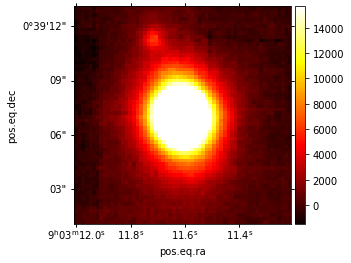

In [2]:
#Frist we read the data cube and transform it in an image
cube = Cube(data_folder+"Data/Cut.fits")
img = cube.sum(axis=0)
img.plot(use_wcs=True,zscale=True, cmap="hot", colorbar="v")

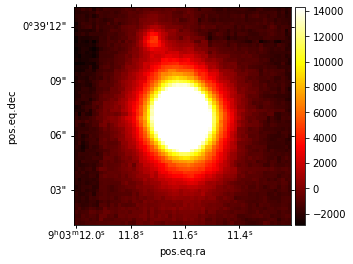

In [3]:
#Now we define some properties of the image
#Proporties of the image

sky = img.background()[0]         #counts/px
scale = 0.2                       #arcsec/px
img = img - sky

img.plot(use_wcs=True,zscale=True, cmap="hot", colorbar="v")

 Pixels used: 711
 Peak Img[j, k]: 29 29
 Mean (j, k): 28.89 29.29
 Theta (deg): 78.1
 Astro PA (deg): 11.9
 Eps: 0.182
 Major axis (pix): 17.3


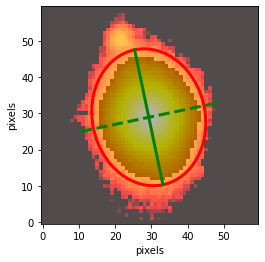

In [4]:
#Now we find some structural properties using find_my_galaxy
f = find_galaxy(img.data.data, fraction=0.2, plot=1)

In [5]:
# To compute the elliptical radius we need that x-axis coincident with the galaxy major axis.
# So we need to rotate the pixel position
def rotate_points(x, y, ang):
    """
    Rotates points conter-clockwise by an angle ANG in degrees.
    Michele cappellari, Paranal, 10 November 2013

    """
    theta = np.radians(ang)
    xNew = x*np.cos(theta) - y*np.sin(theta)
    yNew = x*np.sin(theta) + y*np.cos(theta)

    return xNew, yNew  

##  Using only spaxels with SNR > 1.

In [6]:
y_px, x_px, signal, noise = np.loadtxt('GoodPixels_full.txt', unpack=True)

In [7]:
position = np.column_stack([y_px,x_px])

In [8]:
dr = 0.0
tag = 0
img.data.data[:] = np.nan
while dr < 10:
    for i in range(len(position)):
        rot_x, rot_y = rotate_points(position[i][1]-f.xpeak,position[i][0]-f.ypeak, 90-f.pa)
        r =  scale * np.sqrt(rot_x**2 + (rot_y/(1-f.eps))**2)
        if dr <= r < dr + 0.3:
                img.data.data[int(position[i][0]),int(position[i][1])] =  tag
    dr = dr + 0.3
    tag = tag + 1

img.var.data[:] = np.nan     #Mask the variance

In [9]:
#Write a table with y_position, x_position, Bin_Id
x      = []
y      = []
bin_id = []

for ypx in range(img.shape[0]):
    for xpx in range(img.shape[1]):
        if not np.isnan( img.data.data[ypx,xpx] ):
            y.append(ypx)
            x.append(xpx)
            bin_id.append(img.data.data[ypx,xpx])

#Save Table
np.savetxt('Annealing_GoodBins_Full.txt', np.column_stack([y, x, bin_id]),header="y_px \t x_px \t Bin_Id", fmt=b'%10.6f %10.6f %8i')


Text(0, 0.5, 'arcsec')

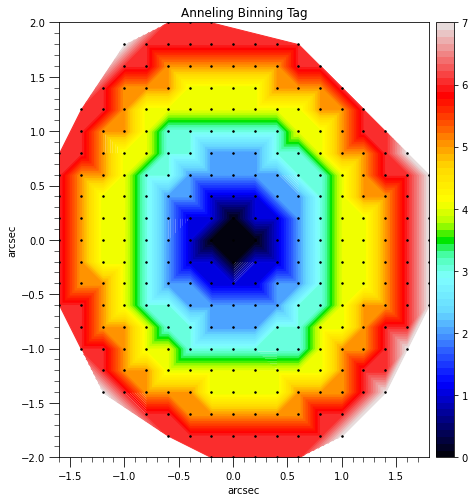

In [10]:
#save in a fits file
img.write(data_folder+"/Data/Annealing_Bin03/Full/Full_Annealing_tag.fits")

plt.figure(figsize=(10,8))
plot_velfield.plot_velfield((x-f.xpeak)*scale,(y-f.ypeak)*scale, bin_id, colorbar=True)
plt.title("Anneling Binning Tag")
plt.xlabel("arcsec")
plt.ylabel("arcsec")